## Описание задачи

Оператор связи хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.


Оператор предоставляет два основных типа услуг:
- Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
- Интернет. Подключение может быть двух типов: через телефонную линию (DSL) или оптоволоконный кабель (Fiber optic).


Также доступны такие услуги:
- Интернет-безопасность: антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity);
- Выделенная линия технической поддержки (TechSupport);
- Облачное хранилище файлов для резервного копирования данных (OnlineBackup);
- Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies).


За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.


Соответственно, **задача**: на основе имеющихся данных выделить целевой признак и построить модель классификации (уйдет пользователь/не уйдет)

## 1 Предобработка данных

Данные состоят из файлов, полученных из разных источников:
- contract_new.csv — информация о договоре;
- personal_new.csv — персональные данные клиента;
- internet_new.csv — информация об интернет-услугах;
- phone_new.csv — информация об услугах телефонии.
 Во всех файлах столбец customerID содержит код клиента.

In [1]:
pip install phik

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install catboost

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import phik

In [4]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score, ConfusionMatrixDisplay, roc_curve
from sklearn.inspection import permutation_importance

Загрузим все имеющиеся данные

In [5]:
contracts = pd.read_csv('https://code.s3.yandex.net/datasets/contract_new.csv')
personal = pd.read_csv('https://code.s3.yandex.net/datasets/personal_new.csv')
internet = pd.read_csv('https://code.s3.yandex.net/datasets/internet_new.csv')
phone = pd.read_csv('https://code.s3.yandex.net/datasets/phone_new.csv')

Создадим необходимые функции для обработки значений

In [6]:
#эта функция переводит значения str в булевы для более удобного использования
def boolean(column_data):
    if column_data == 'Yes':
        return 1
    elif column_data == 'No':
        return 0
    else:
        return np.nan

In [7]:
#эта функция переводит значения в тип float, а при отсутствии значений или неподдерживаемом формате вставляет NaN
def float_number(column_data):
    try:
        return float(column_data)
    except:
        return np.nan

In [8]:
#эта функция возвращает 0, если значение в столбце NaN, и 1 - если нет, нужна для сравнения количества значений в таблицах
def is_it(column_data):
    if np.isnan(column_data):
        return 0
    else:
        return 1

In [9]:
#эта функция переводит столбец с гендером в бинарный вид, где 0 - мужчина, 1 - женщина
def gender(column_data):
    if column_data == 'Male':
        return 0
    else:
        return 1

Рассмотрим информацию о договорах

In [10]:
contracts.head(15)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5
5,9305-CDSKC,2019-03-01,No,Month-to-month,Yes,Electronic check,99.65,1150.96
6,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,2058.21
7,6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,300.48
8,7892-POOKP,2017-07-01,No,Month-to-month,Yes,Electronic check,104.80,3573.68
9,6388-TABGU,2014-12-01,2017-05-01,One year,No,Bank transfer (automatic),56.15,1628.35


- BeginDate – дата начала пользования услугами,
- EndDate – дата окончания пользования услугами,
- Type – тип оплаты: ежемесячный, годовой и тд,
- PaperlessBilling – электронный платёжный документ,
- PaymentMethod – способ оплаты,
- MonthlyCharges – ежемесячные траты на услуги,
- TotalCharges – всего потрачено денег на услуги


Проверим наличие явных дубликатов

In [11]:
contracts.duplicated().sum()

0

Явных дубликатов по пользователям нет

In [12]:
contracts['PaymentMethod'].unique()

array(['Electronic check', 'Mailed check', 'Bank transfer (automatic)',
       'Credit card (automatic)'], dtype=object)

In [13]:
contracts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


Некоторые столбцы имеют некорректный тип данных. Столбцы с датами начала и окончания использования услуг стоит привести к datetime для корректного использования. PaperlessBilling можно привести к булевым значениям. TotalCharges нужно перевести во float.

Для будущего выделения дополнительных признаков для исследования имеет смысл создать столбец, содержащий дату ухода пользователся и, если пользователь не ушел, актуальную дату (1 февраля 2020 года). Это нужно для того, чтобы далее посмотреть, сколько времени уже длится договор с пользователем. Создадим столбец EndDate_copy, где все значения 'No' будут заменены на текущую дату.

In [14]:
contracts['EndDateCopy'] = np.where(contracts['EndDate'] == 'No', '2020-02-01', contracts['EndDate'])

Переведем его в тип datetime

In [15]:
contracts['EndDateCopy'] = pd.to_datetime(contracts['EndDateCopy'], format='%Y-%m-%d')

Приведем дату начала использования услуг к datetime

In [16]:
contracts['BeginDate'] = pd.to_datetime(contracts['BeginDate'], format='%Y-%m-%d')

Приведем для удобства столбец PaperlessBilling к булевому типу

In [17]:
contracts['PaperlessBilling'] = contracts['PaperlessBilling'].agg(boolean)

Приведем столбец TotalCharges к типу float, пропуски будут заменены на NaN

In [18]:
contracts['TotalCharges'] = contracts['TotalCharges'].agg(float_number)

Выделим целевой признак для будущей классификации - уход клиента.

In [19]:
contracts['Left'] = np.where(contracts['EndDate'] == 'No', 0, 1)

Также выделим количество дней с начала договора 

In [20]:
contracts['TimeDeltaDays'] = (contracts['EndDateCopy'] - contracts['BeginDate']).dt.days

In [21]:
contracts.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,EndDateCopy,Left,TimeDeltaDays
0,7590-VHVEG,2020-01-01,No,Month-to-month,1,Electronic check,29.85,31.04,2020-02-01,0,31
1,5575-GNVDE,2017-04-01,No,One year,0,Mailed check,56.95,2071.84,2020-02-01,0,1036
2,3668-QPYBK,2019-10-01,No,Month-to-month,1,Mailed check,53.85,226.17,2020-02-01,0,123
3,7795-CFOCW,2016-05-01,No,One year,0,Bank transfer (automatic),42.30,1960.60,2020-02-01,0,1371
4,9237-HQITU,2019-09-01,No,Month-to-month,1,Electronic check,70.70,353.50,2020-02-01,0,153


In [22]:
contracts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   object        
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   int64         
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
 8   EndDateCopy       7043 non-null   datetime64[ns]
 9   Left              7043 non-null   int32         
 10  TimeDeltaDays     7043 non-null   int64         
dtypes: datetime64[ns](2), float64(2), int32(1), int64(2), object(4)
memory usage: 577.9+ KB


Теперь все данные приведены к необходимому типу

In [23]:
contracts.isna().sum()

customerID           0
BeginDate            0
EndDate              0
Type                 0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
EndDateCopy          0
Left                 0
TimeDeltaDays        0
dtype: int64

Появились пропуски, которые будут обработаны после соединения таблиц

Рассмотрим основные статистические величины по данным

In [24]:
contracts.describe()

,PaperlessBilling,MonthlyCharges,TotalCharges,Left,TimeDeltaDays
count,7043.000000,7043.000000,7032.000000,7043.000000,7043.000000
mean,0.592219,64.761692,2118.621822,0.156325,898.555729
std,0.491457,30.090047,2112.736199,0.363189,683.130510
min,0.000000,18.250000,19.050000,0.000000,0.000000
25%,0.000000,35.500000,439.745000,0.000000,276.000000
50%,1.000000,70.350000,1345.275000,0.000000,761.000000
75%,1.000000,89.850000,3239.317500,0.000000,1461.000000
max,1.000000,118.750000,9221.380000,1.000000,2314.000000


Каких-либо очевидных аномалий нет, в time_delta_days присутствуют нулевые значения, они могут относиться к только что зарегистрировавшимся пользователям на момент 1 февраля 2020 года. Видно, что разброс в TotalCharges очень широкий, вероятно, потому что траты тех, кто давно заключил договор, значительно выше, чем тех, кто недавно пользуется услугами. Рассмотрим гистограммы.

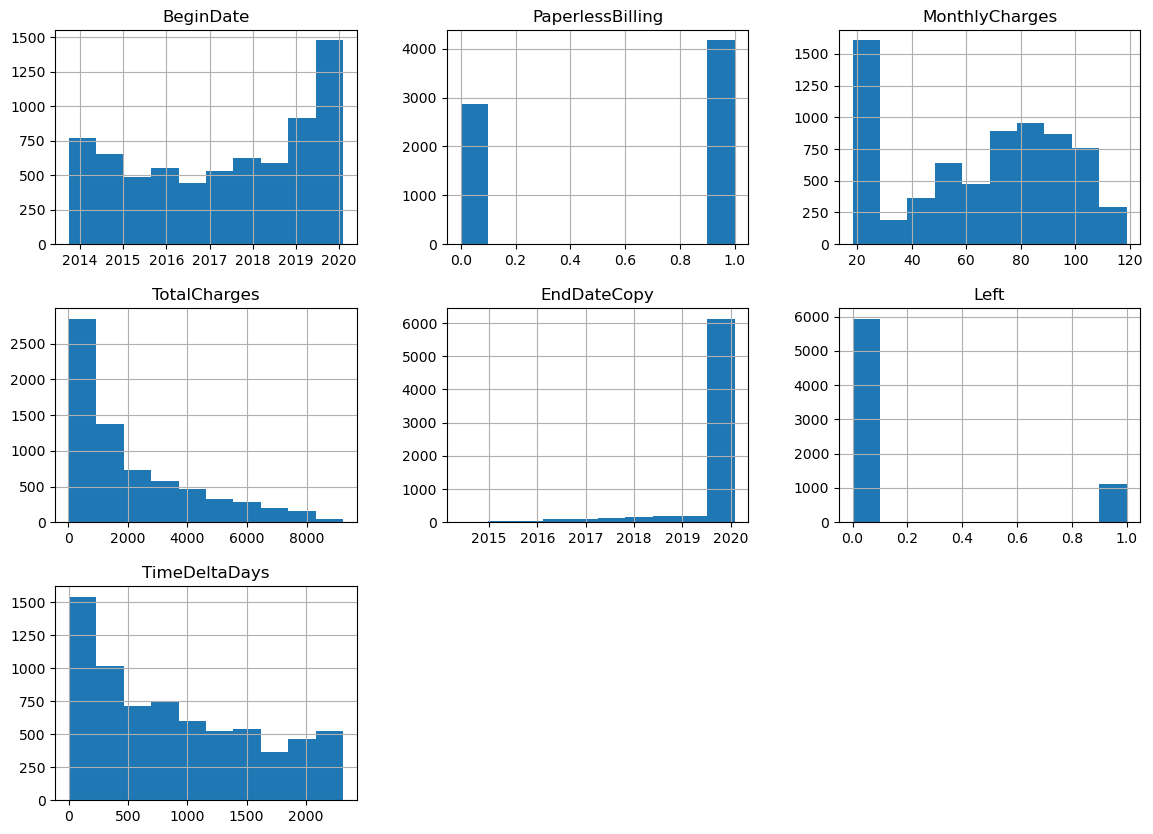

In [25]:
contracts.hist(figsize=(14, 10));

Судя по BeginDate, в 2016-2017 шел отток пользователей, но за последние два года количество пользователей значительно выросло. Большая часть пользователей пользуется электронными счетами. Судя по MonthlyCharges большинство пользователей старается тратить минимально возможное количество денег на услуги, но также есть пользователи, использующие более дорогостоящие услуги. В целом, судя по гауссовскому распределению в TotalCharges, все же большей популярностью пользуются самые дешевые услуги. В целевом признаке Left присутствует явный дисбаланс классов: количество ушедших пользователей значительно меньше количества пользователей, пользующихся услугами.

Рассмотрим персональные данные клиентов

In [26]:
personal.head(15)

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
5,9305-CDSKC,Female,0,No,No
6,1452-KIOVK,Male,0,No,Yes
7,6713-OKOMC,Female,0,No,No
8,7892-POOKP,Female,0,Yes,No
9,6388-TABGU,Male,0,No,Yes


- Dependents – наличие иждивенцев
- Senior Citizen – наличие пенсионного статуса по возрасту
- Partner – наличие супруга(и)

Проверим наличие явных дубликатов

In [27]:
personal.duplicated().sum()

0

Явных дубликатов нет. Посмотрим информацию о данных

In [28]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


Столбцы Partner и Dependents имеет смысл привести к булеву типу для удобства.

In [29]:
personal['Partner'] = personal['Partner'].agg(boolean)
personal['Dependents'] = personal['Dependents'].agg(boolean)
personal['gender'] = personal['gender'].agg(gender)

Посмотрим на распределения величин

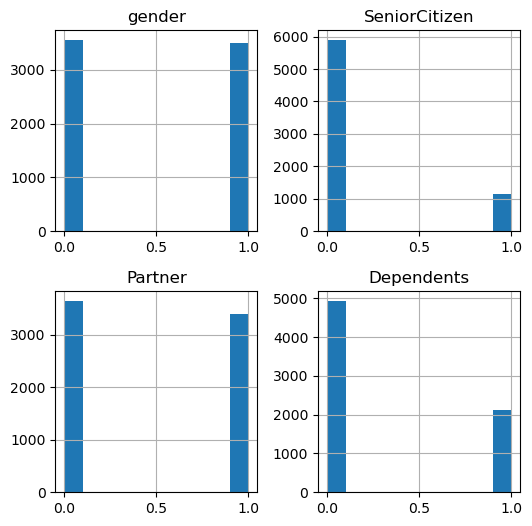

In [30]:
personal.hist(figsize=(6,6));

Пользователей в пенсионном возрасте значительно меньше, чем более молодых. Количество пользователей в браке и не в браке примерно одинаково. Заметно меньше пользователей с иждивенцем, чем без.

Проверим данные на наличие пропусков

In [31]:
personal.isna().sum()

customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64

Значений NaN в таблице нет, а количество строк такое же, как и в таблице contracts

Рассмотрим информацию об интернет-услугах

In [32]:
internet.head(15)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No
5,9305-CDSKC,Fiber optic,No,No,Yes,No,Yes,Yes
6,1452-KIOVK,Fiber optic,No,Yes,No,No,Yes,No
7,6713-OKOMC,DSL,Yes,No,No,No,No,No
8,7892-POOKP,Fiber optic,No,No,Yes,Yes,Yes,Yes
9,6388-TABGU,DSL,Yes,Yes,No,No,No,No


Проверим наличие явных дубликатов

In [33]:
internet.duplicated().sum()

0

In [34]:
internet['InternetService'].unique()

array(['DSL', 'Fiber optic'], dtype=object)

Явных дубликатов нет. Посмотрим информацию о таблице

In [35]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


В этой таблице меньше строк, чем в таблице contracts. Очевидно, не все пользователи подключали Интернет. Все столбцы, относящиеся к опциям, можно привести к булевым значениям.

In [36]:
internet['OnlineSecurity'] = internet['OnlineSecurity'].agg(boolean)
internet['OnlineBackup'] = internet['OnlineBackup'].agg(boolean)
internet['DeviceProtection'] = internet['DeviceProtection'].agg(boolean)
internet['TechSupport'] = internet['TechSupport'].agg(boolean)
internet['StreamingTV'] = internet['StreamingTV'].agg(boolean)
internet['StreamingMovies'] = internet['StreamingMovies'].agg(boolean)

Проверим данные на наличие пропусков

In [37]:
internet.isna().sum()

customerID          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64

Значений NaN в таблице нет

Рассмотрим распределения по величинам

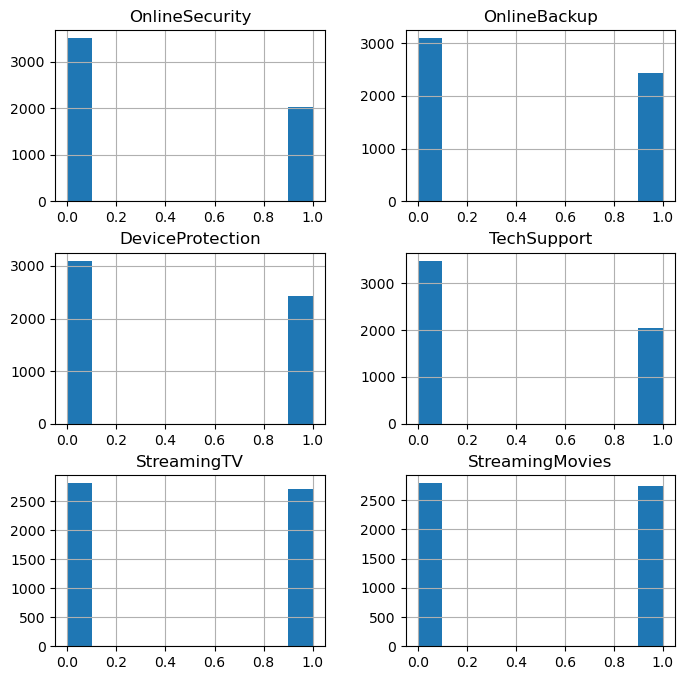

In [38]:
internet.hist(figsize=(8,8));

В целом, большинство функций подключают от трети до половины пользователей

Рассотрим последнюю таблицу - данные о телефонии

In [39]:
phone.head(15)

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes
5,7892-POOKP,Yes
6,6388-TABGU,No
7,9763-GRSKD,No
8,7469-LKBCI,No
9,8091-TTVAX,Yes


- MultipleLines – наличие возможности ведения параллельных линий во время звонка

In [40]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


В этой таблице так же, как и в таблице с данными об Интернет-услугах, меньше строк, чем в таблице с информацией о договорах. Вероятно, часть пользователей подключала только Интернет.

Приведем MultipleLines к булевому типу

In [41]:
phone['MultipleLines'] = phone['MultipleLines'].agg(boolean)

Проверим наличие дубликатов

In [42]:
phone.duplicated().sum()

0

Явных дубликатов нет. Посмотрим распределение данных

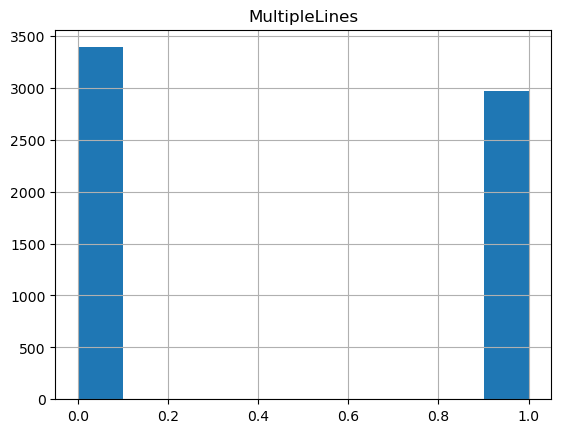

In [43]:
phone.hist();

Среди подключивших телефонию нет явного перевеса пользователей, подключивших или не подключивших возможность ведения параллельных линий во время звонка.

Соединим таблицы по customerID

In [44]:
all_data = contracts.merge(personal, on='customerID', how='left') 
all_data = all_data.merge(internet, on='customerID', how='left')
all_data = all_data.merge(phone, on='customerID', how='left')

In [45]:
all_data.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,EndDateCopy,Left,...,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,1,Electronic check,29.85,31.04,2020-02-01,0,...,1,0,DSL,0.0,1.0,0.0,0.0,0.0,0.0,NaN
1,5575-GNVDE,2017-04-01,No,One year,0,Mailed check,56.95,2071.84,2020-02-01,0,...,0,0,DSL,1.0,0.0,1.0,0.0,0.0,0.0,0.0
2,3668-QPYBK,2019-10-01,No,Month-to-month,1,Mailed check,53.85,226.17,2020-02-01,0,...,0,0,DSL,1.0,1.0,0.0,0.0,0.0,0.0,0.0
3,7795-CFOCW,2016-05-01,No,One year,0,Bank transfer (automatic),42.30,1960.60,2020-02-01,0,...,0,0,DSL,1.0,0.0,1.0,1.0,0.0,0.0,NaN
4,9237-HQITU,2019-09-01,No,Month-to-month,1,Electronic check,70.70,353.50,2020-02-01,0,...,0,0,Fiber optic,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [46]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   object        
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   int64         
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
 8   EndDateCopy       7043 non-null   datetime64[ns]
 9   Left              7043 non-null   int32         
 10  TimeDeltaDays     7043 non-null   int64         
 11  gender            7043 non-null   int64         
 12  SeniorCitizen     7043 non-null   int64         
 13  Partner           7043 non-null   int64         
 14  Dependents        7043 n

Количество соответствующих строк в итоговой таблице совпадает с количеством строк для каждой из таблиц, данные не потерялись

Посмотрим на наличие пропусков в сводной таблице

In [47]:
all_data.isna().sum().sort_values()

customerID             0
Dependents             0
Partner                0
SeniorCitizen          0
TimeDeltaDays          0
Left                   0
EndDateCopy            0
gender                 0
MonthlyCharges         0
PaymentMethod          0
PaperlessBilling       0
Type                   0
EndDate                0
BeginDate              0
TotalCharges          11
MultipleLines        682
StreamingMovies     1526
InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
dtype: int64

Действительно, при соединении разница количества строк в таблицах выразилась в наличие пропусков. Пропуски в наличии той или иной функции имеет смысл заменить 0, потому что, логично, что эту функцию человек не использует, если он не подключал Интернет или телефон. Можно попробовать выделить столбцы, отражающие наличие подключенной телефонии и Интернета. Пропуск в TotalCharges имеет смысл заполнить медианным значением, чтобы не было сильного смещения значения в большую сторону, так как из распределения мы видели, что оно близко к распределению Гаусса. 

In [48]:
all_data[all_data['TotalCharges'].isna()]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,EndDateCopy,Left,...,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
488,4472-LVYGI,2020-02-01,No,Two year,1,Bank transfer (automatic),52.55,NaN,2020-02-01,0,...,1,1,DSL,1.0,0.0,1.0,1.0,1.0,0.0,NaN
753,3115-CZMZD,2020-02-01,No,Two year,0,Mailed check,20.25,NaN,2020-02-01,0,...,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
936,5709-LVOEQ,2020-02-01,No,Two year,0,Mailed check,80.85,NaN,2020-02-01,0,...,1,1,DSL,1.0,1.0,1.0,0.0,1.0,1.0,0.0
1082,4367-NUYAO,2020-02-01,No,Two year,0,Mailed check,25.75,NaN,2020-02-01,0,...,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
1340,1371-DWPAZ,2020-02-01,No,Two year,0,Credit card (automatic),56.05,NaN,2020-02-01,0,...,1,1,DSL,1.0,1.0,1.0,1.0,1.0,0.0,NaN
3331,7644-OMVMY,2020-02-01,No,Two year,0,Mailed check,19.85,NaN,2020-02-01,0,...,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3826,3213-VVOLG,2020-02-01,No,Two year,0,Mailed check,25.35,NaN,2020-02-01,0,...,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
4380,2520-SGTTA,2020-02-01,No,Two year,0,Mailed check,20.00,NaN,2020-02-01,0,...,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
5218,2923-ARZLG,2020-02-01,No,One year,1,Mailed check,19.70,NaN,2020-02-01,0,...,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
6670,4075-WKNIU,2020-02-01,No,Two year,0,Mailed check,73.35,NaN,2020-02-01,0,...,1,1,DSL,0.0,1.0,1.0,1.0,1.0,0.0,1.0


Пропуски в TotalCharges вызваны тем, что это только что зарегистрировавшиеся пользователи, тогда стоит заменить их 0

Выделим столбцы, обозначающие, подключил ли пользователь телефон или Интернет

In [49]:
all_data['IsTelephone'] = all_data['MultipleLines'].agg(is_it)

In [50]:
all_data['IsInternet'] = all_data['StreamingMovies'].agg(is_it)

Заменим пропуски в TotalCharges нулями

In [51]:
all_data['TotalCharges'] = all_data['TotalCharges'].fillna(0)

Остальные пропуски (в наличии услуг) заменим заглушкой - нет подключенной услуги (not_used)

In [52]:
all_data = all_data.fillna('not_used')

In [53]:
all_data.isna().sum().sort_values()

customerID          0
MultipleLines       0
StreamingMovies     0
StreamingTV         0
TechSupport         0
DeviceProtection    0
OnlineBackup        0
OnlineSecurity      0
InternetService     0
Dependents          0
Partner             0
IsTelephone         0
SeniorCitizen       0
TimeDeltaDays       0
Left                0
EndDateCopy         0
TotalCharges        0
MonthlyCharges      0
PaymentMethod       0
PaperlessBilling    0
Type                0
EndDate             0
BeginDate           0
gender              0
IsInternet          0
dtype: int64

Мы избавились от пропусков

Оставим исходную стилистику названий, не будем переводить в нижний регистр и разделять, потому что так, как есть на данный момент, читабельнее.

In [54]:
all_data = all_data.rename(columns={'gender' : 'Gender'})

In [55]:
all_data.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,EndDateCopy,Left,...,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,IsTelephone,IsInternet
0,7590-VHVEG,2020-01-01,No,Month-to-month,1,Electronic check,29.85,31.04,2020-02-01,0,...,DSL,0.0,1.0,0.0,0.0,0.0,0.0,not_used,0,1
1,5575-GNVDE,2017-04-01,No,One year,0,Mailed check,56.95,2071.84,2020-02-01,0,...,DSL,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1,1
2,3668-QPYBK,2019-10-01,No,Month-to-month,1,Mailed check,53.85,226.17,2020-02-01,0,...,DSL,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1,1
3,7795-CFOCW,2016-05-01,No,One year,0,Bank transfer (automatic),42.30,1960.60,2020-02-01,0,...,DSL,1.0,0.0,1.0,1.0,0.0,0.0,not_used,0,1
4,9237-HQITU,2019-09-01,No,Month-to-month,1,Electronic check,70.70,353.50,2020-02-01,0,...,Fiber optic,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1


In [56]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   object        
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   int64         
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   EndDateCopy       7043 non-null   datetime64[ns]
 9   Left              7043 non-null   int32         
 10  TimeDeltaDays     7043 non-null   int64         
 11  Gender            7043 non-null   int64         
 12  SeniorCitizen     7043 non-null   int64         
 13  Partner           7043 non-null   int64         
 14  Dependents        7043 n

Данные изменены корректно, пропусков нет

**Итог преобработки:**
- Данные загружены, проверены на наличие дубликатов и наличие аномалий, явных дубликатов и аномалий нет;
- Некоторые некорректные типы данных исправлены;
- Часть столбцов приведена к булевым значениям для удобства;
- Таблицы соединены в общую, пропуски в данных обработаны;
- Выделен целевой признак (Left), обозначающий отказ пользователя от всех услуг.


**Первичные выводы о данных:**
1) В 2016-2017 годах шел отток пользователей, но за последние два года количество пользователей значительно выросло;
2) Большинство Интернет-функций подключают от трети до половины пользователей;
3) Большинство пользователей старается тратить минимально возможное количество денег на услуги;
4) Пользователей в пенсионном возрасте значительно меньше, чем более молодых;
5) Заметно меньше пользователей с иждивенцем, чем без;
6) В целевом признаке присутствует явный дисбаланс классов: количество ушедших пользователей значительно меньше количества пользователей, пользующихся услугами.

## 2 Исследовательский анализ данных

Выделим числовые признаки

In [57]:
numeric = ['MonthlyCharges', 'TimeDeltaDays', 'TotalCharges']

Посмотрим, есть ли среди них аномалии, при помощи боксплотов. Построим боксплот для каждого столбца

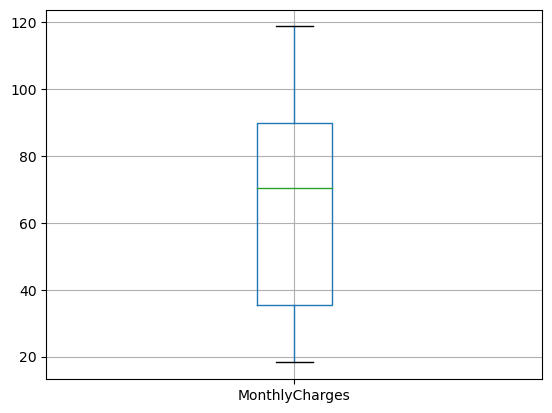

In [58]:
all_data.boxplot(column=numeric[0]);

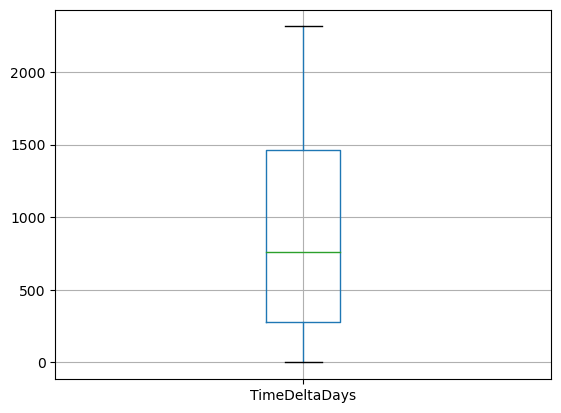

In [59]:
all_data.boxplot(column=numeric[1]);

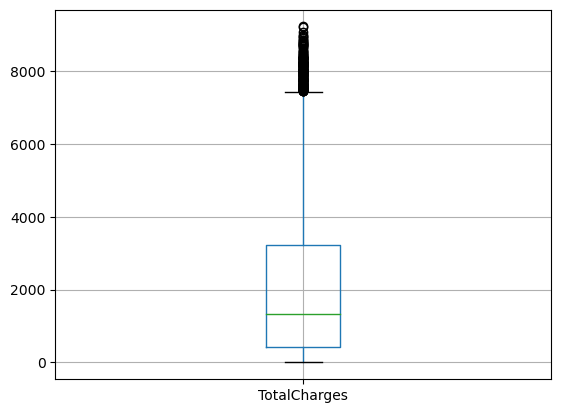

In [60]:
all_data.boxplot(column=numeric[2]);

В TotalCharges присуттсвуют значения, выходящие за пределы 3-х сигм, но их не стоит убирать, так как они не сильно искажают данные, но смещают распределение

Посмотрим на зависимости в числовых переменных при помощи стандартной матрицы корреляции

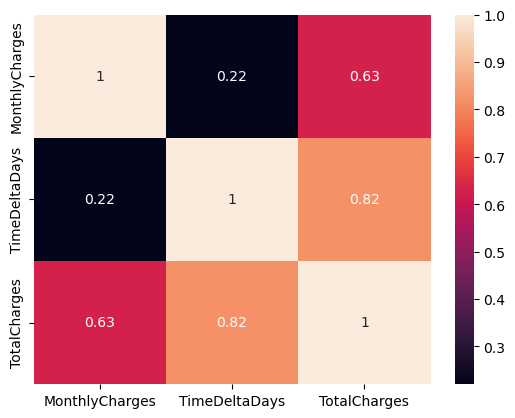

In [61]:
sns.heatmap(all_data[numeric].corr(), annot=True);

Можно сделать очевидный вывод, что чем больше времени пользователь пользовался услугами, тем больше денег он потратил на них, а вот сильной зависимости между ежемесячными платежами и длительностью договора с пользователем нет

Посмотрим на зависимости в категориальных переменных при помощи матрицы корреляции Фика

interval columns not set, guessing: ['PaperlessBilling', 'MonthlyCharges', 'TotalCharges', 'Left', 'TimeDeltaDays', 'Gender', 'SeniorCitizen', 'Partner', 'Dependents', 'IsTelephone', 'IsInternet']


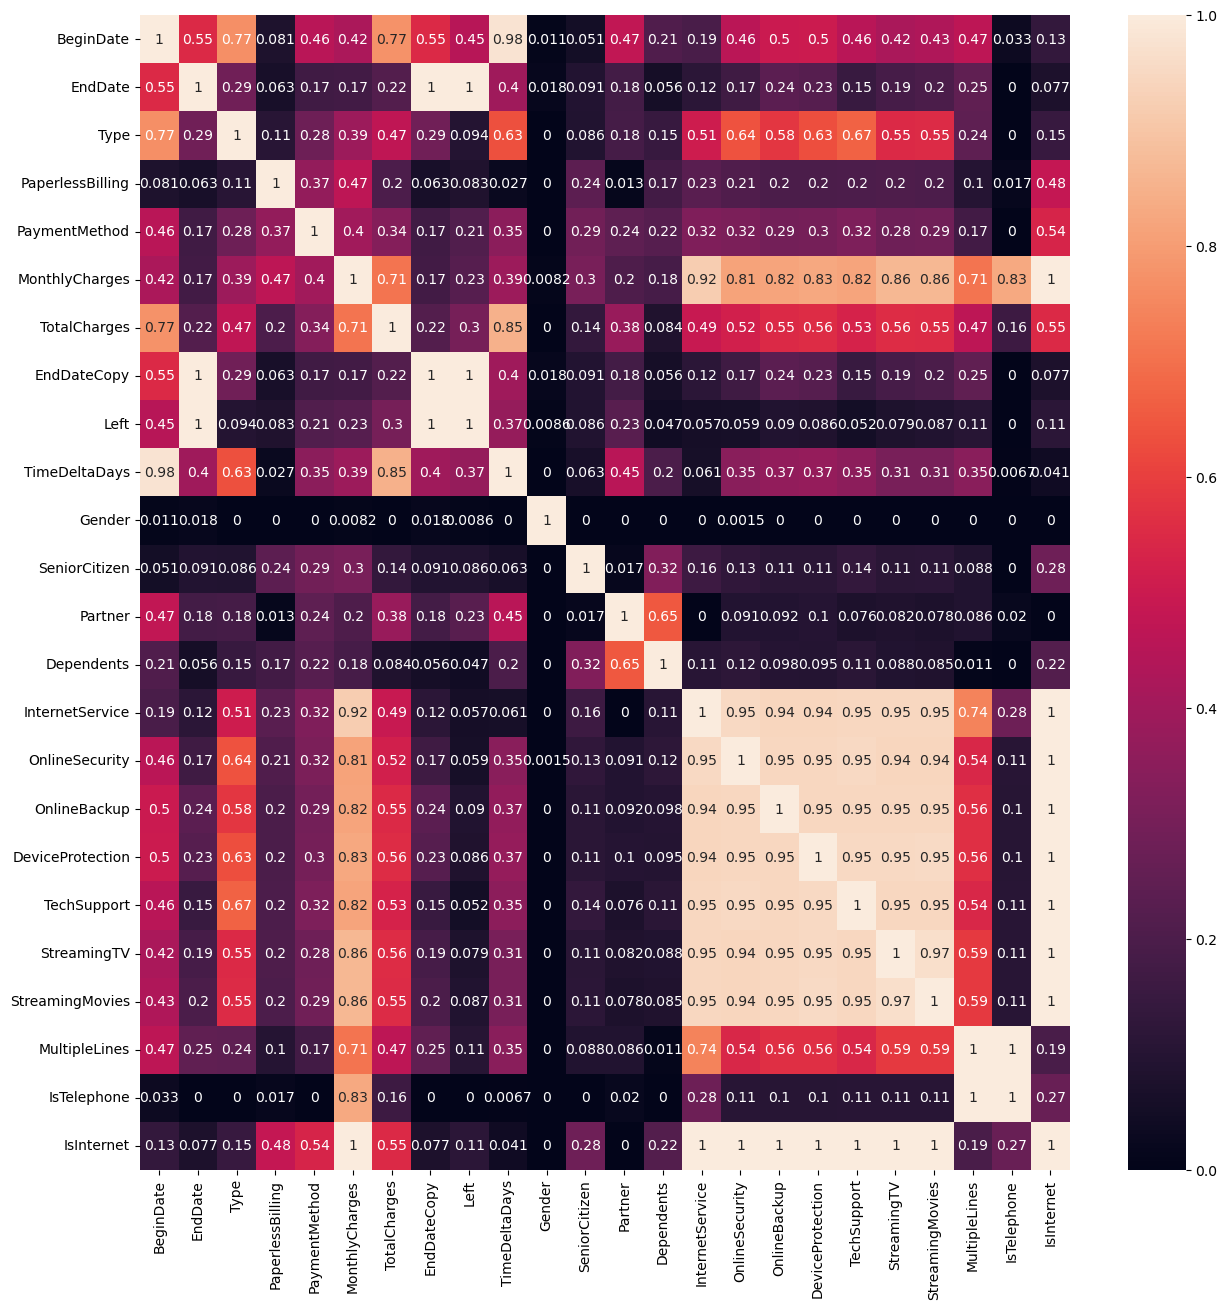

In [62]:
plt.figure(figsize=(15, 15), dpi=100)
ax = sns.heatmap(all_data.drop('customerID', axis=1).phik_matrix(), annot=True);

Попробуем сначала выявить зависимости между признаками
- Есть зависимость между датой начала договора и типом оплаты, способом оплаты, общей потраченной пользователем суммой, целевым признаком, наличием партнера и наличием дополнительных опций;
- Есть зависимость между типом оплаты и общими тратами, количеством дней договора и наличием функции InternetService
- Есть зависимость между отказом от получения бумажных счетов и типом оплаты, месячными тратами, наличием подключенного Интернета и некоторых функций
- Есть зависимость между методом оплаты и тратами, как месячными, так и общими, количеством дней договора, наличием допуслуг и Интернета
- Наибольший вклад в текущие месячные расходы вносит наличие Интернета, немного меньше - телефонии, и еще меньше - допуслуг, наибольший вклад из которых - Интернет-сервисы и стриминговые сервисы
- Общие расходы также напрямую связаны с наличием Интернета и допуслуг, а вот телефона - нет. Также есть зависимость с наличием супруга/ги
- Есть зависимости между наличием некоторых услуг - их могут подключать совместно
- Количество дней договора связано с наличием супруга/ги и допфункций
- Наличие иждивенцев связано с наличием партнера и возрастом

Самые влияющие на целевой признак факторы: дата начала договора, количество дней договора и общие расходы. Общие расходы тесно связаны с текущими месячными расходами, которые, в свою очередь зависят от наличия Интернета и подключаемых услуг. 

Попробуем выделить зависимости

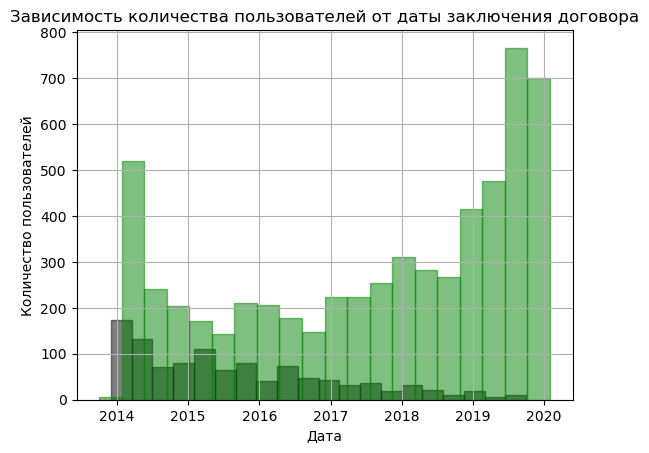

In [63]:
ax = all_data.query('Left == 1')['BeginDate'].hist(alpha=0.5, color='black', edgecolor='black', bins=20, label='Ушли')
ax = all_data.query('Left == 0')['BeginDate'].hist(alpha=0.5, color='green', edgecolor='green', bins=20, label='Остались')
ax.set_title('Зависимость количества пользователей от даты заключения договора')
ax.set_xlabel('Дата')
ax.set_ylabel('Количество пользователей');

Больше всего расторгающих договора людей среди давно зарегистрированных пользователей, при этом есть люди, которые, наоборот, как пользовались услугами, так и продолжают ими пользоваться в течение уже 6 лет

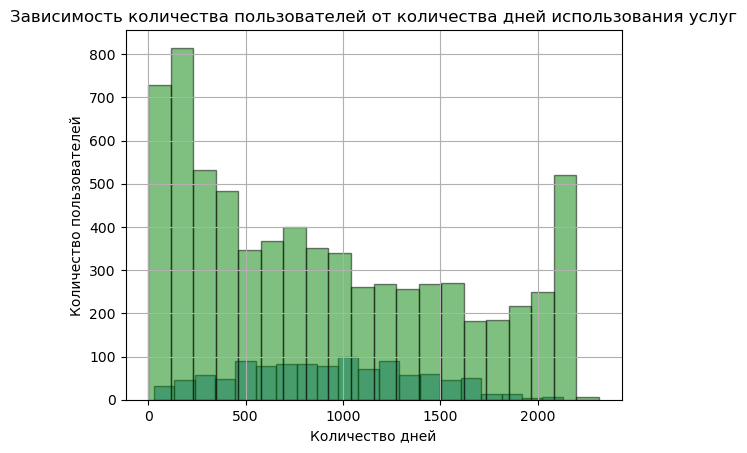

In [64]:
ax = all_data.query('Left == 1')['TimeDeltaDays'].hist(edgecolor='black', bins=20, alpha=0.5)
all_data['TimeDeltaDays'].hist(color='green', edgecolor='black', bins=20, alpha=0.5)
ax.set_title('Зависимость количества пользователей от количества дней использования услуг')
ax.set_xlabel('Количество дней')
ax.set_ylabel('Количество пользователей');

Можно увидеть, что большинство людей, которые отказались от услуг, сделали это в промежутке от 500 до 1100 дней использования. Большинство пользующихся услугами людей - новые пользователи

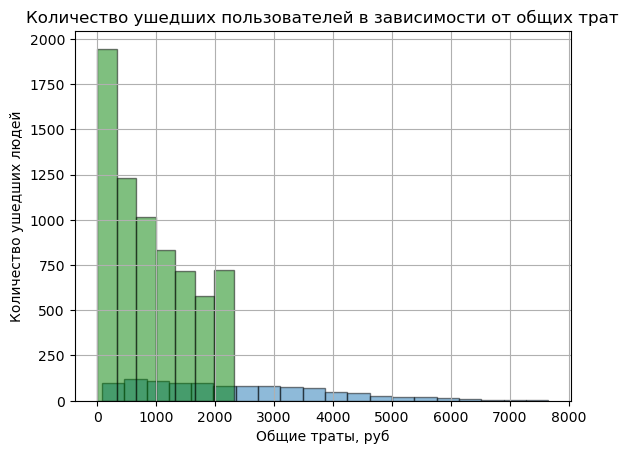

In [65]:
ax = all_data.query('Left == 1')['TotalCharges'].hist(edgecolor='black', bins=20, alpha=0.5)
all_data['TimeDeltaDays'].hist(color='green', edgecolor='black', bins = 7, alpha=0.5)
ax.set_title('Количество ушедших пользователей в зависимости от общих трат')
ax.set_xlabel('Общие траты, руб')
ax.set_ylabel('Количество ушедших людей');

Большинство отказывающихся от услуг людей делают это при малых общих тратах, значит, скорее всего, и при минимальной оплате услуг в течение относительно недолгого времени использования услуг. Но при этом ттраты большинства пользователей ограничены ~2500 тысячами рублей. Вероятно, новые пользователи как легко приходят в больших количествах, так и уходят больше из-за этого фактора.

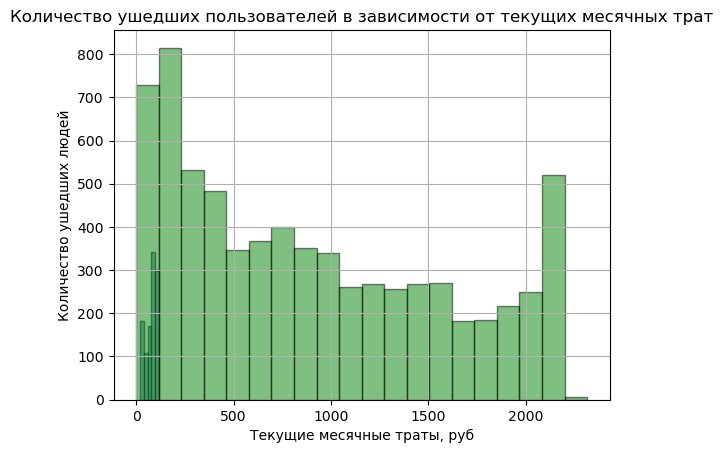

In [66]:
ax = all_data.query('Left == 1')['MonthlyCharges'].hist(edgecolor='black', bins=5 , alpha=0.5)
all_data['TimeDeltaDays'].hist(color='green', edgecolor='black', bins = 20, alpha=0.5)
ax.set_title('Количество ушедших пользователей в зависимости от текущих месячных трат')
ax.set_xlabel('Текущие месячные траты, руб')
ax.set_ylabel('Количество ушедших людей');

Можно заметить, что наибольшее количество людей отказывается от услуг при относительно малых ежемесячных тратах.

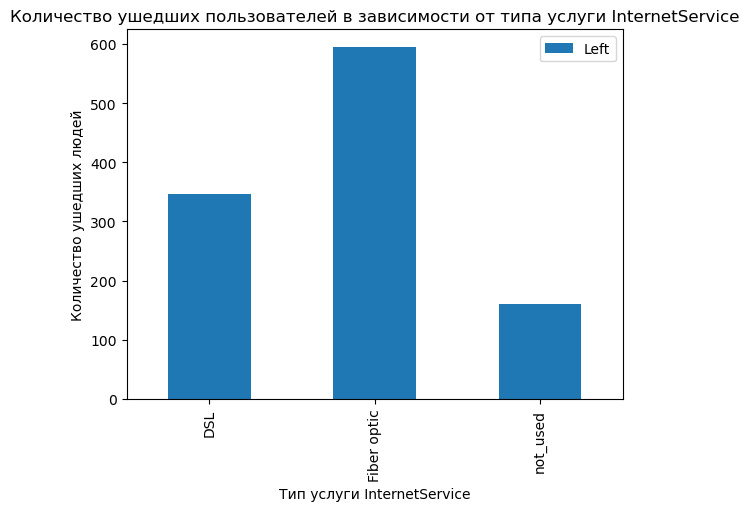

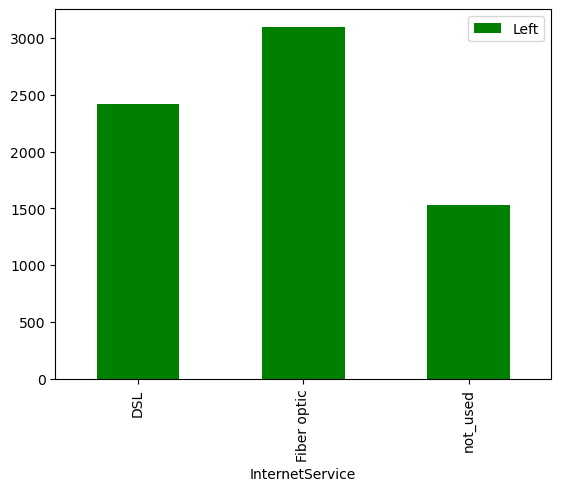

In [67]:
ax = (all_data
 .query('Left == 1')
 .pivot_table(index='InternetService', values='Left', aggfunc="count")
 .plot(kind='bar', label=False)
)
(all_data
 .pivot_table(index='InternetService', values='Left', aggfunc="count")
 .plot(kind='bar', label=False, color='green')
)
ax.set_title('Количество ушедших пользователей в зависимости от типа услуги InternetService')
ax.set_xlabel('Тип услуги InternetService')
ax.set_ylabel('Количество ушедших людей');

Большинство отказов от договоров связано с клиентами, подключившими Fiber optic, при этом есть сильная связь между этим сервисом и ежемесячными тратами. Но, с другой стороны, большинство клиентов и подключают Fiber optic.

In [68]:
OnlineSecuritySum = all_data.query('Left == 1 and OnlineSecurity == 1')['OnlineSecurity'].count()
OnlineBackupSum = all_data.query('Left == 1 and OnlineBackup == 1')['OnlineBackup'].count()
DeviceProtectionSum = all_data.query('Left == 1 and DeviceProtection == 1')['DeviceProtection'].count()
TechSupportSum = all_data.query('Left == 1 and TechSupport == 1')['TechSupport'].count()
StreamingTVSum = all_data.query('Left == 1 and StreamingTV == 1')['StreamingTV'].count()
StreamingMoviesSum = all_data.query('Left == 1 and StreamingMovies == 1')['StreamingMovies'].count()
MultipleLinesSum = all_data.query('Left == 1 and MultipleLines == 1')['MultipleLines'].count()
all_sums = [OnlineSecuritySum, OnlineBackupSum, DeviceProtectionSum, TechSupportSum, StreamingTVSum, StreamingMoviesSum, MultipleLinesSum]
names = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines']


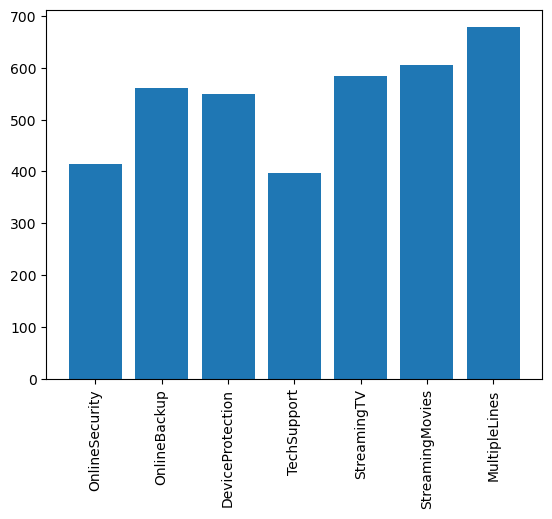

In [69]:
plt.bar(names, all_sums)
plt.xticks(rotation=90);

Больше всего отказавшихся от договоров подключали услугу MultipLines, но какого-то явного отрыва от других услуг по количеству ушедших пользователей нет

Итог: 
- Зависимости между ежемесячными платежами и длительностью договора с пользователем нет
- Количество дней договора связано с наличием супруга/ги и допфункций
- Есть зависимости между наличием некоторых услуг - их могут подключать совместно
- Расходы напрямую связаны с наличием Интернета и допуслуг, а вот телефона - нет. Также есть зависимость с наличием супруга/ги
- Есть зависимость между количеством дней договора и наличием функции InternetService. Большинство отказов от договоров связано с клиентами, подключившими Fiber optic.
- Есть зависимость между методом оплаты и тратами, как месячными, так и общими, количеством дней договора, наличием допуслуг и Интернета
- Наибольший вклад в текущие месячные расходы вносит наличие Интернета, немного меньше - телефонии, и еще меньше - допуслуг, наибольший вклад из которых - Интернет-сервисы и стриминговые сервисы
- Самые влияющие на целевой признак факторы: дата начала договора, количество дней договора и общие расходы. Общие расходы тесно связаны с текущими месячными расходами, которые, в свою очередь зависят от наличия Интернета и подключаемых услуг
- Большинство людей, которые отказались от услуг, сделали это в промежутке от 500 до 1100 дней использования
- Наибольшее количество людей отказывается от услуг при больших ежемесячных тратах, но есть также большая часть, которая отказывается и при малых.

**Вывод:** наиболее значимый фактор, влияющий на целевой признак - траты пользователя. При этом на траты влияют подключенные услуги, одна из которых, InternetService типа Fiber optic, имеет зависимость с большинством отказов пользователей. Возможно, в этом есть проблема. При этом в большинсвте пользователи долго остаются с компанией. Большинство ушедших пользователей имело высокие ежемесячные траты, но многие также уходили и с малыми, распределение имеет два пика, поэтому очевидной прямой зависимости здесь нет.


**Примерный план решения задачи:**
1) Подготовка данных:
- убрать лишние признаки (EndDate, EndDate_copy). Рассмотреть, возможно убрать еще некоторые коллинеарные между собой признаки;
- разбить данные на 2 выборки, учитывая дисбаланс классов;


2) Обучение модели: 
- через пайплайн посмотреть наиболее подходящий вариант предобработки данных, наиболее подходящую модель;


3) Тестирование:
- проверить лучшую модель на тестовой выборке и метриках auc-roc и accuracy;
- оценить, какие факторы модель выделила наиболее значимыми.


**Цель проекта:** обучить модель, которая будет предсказывать, уйдет ли пользователь или нет, чтобы предотвратить его уход.

## 3 Подготовка данных к обучению модели

Так как у нас есть количество дней регистрации, можно убрать даты, которые сложно закодировать. Также присутствует коллинеарность между всеми дополнительными функциями, имеет смысл убрать эти признаки, так как есть отдельные столбцы, овтечающие за наличие телефона и Интернета

In [70]:
drop = ['EndDate', 'customerID', 'EndDateCopy', 'BeginDate'] + names

In [71]:
model_data = all_data.drop(drop, axis = 1)

In [72]:
model_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              7043 non-null   object 
 1   PaperlessBilling  7043 non-null   int64  
 2   PaymentMethod     7043 non-null   object 
 3   MonthlyCharges    7043 non-null   float64
 4   TotalCharges      7043 non-null   float64
 5   Left              7043 non-null   int32  
 6   TimeDeltaDays     7043 non-null   int64  
 7   Gender            7043 non-null   int64  
 8   SeniorCitizen     7043 non-null   int64  
 9   Partner           7043 non-null   int64  
 10  Dependents        7043 non-null   int64  
 11  InternetService   7043 non-null   object 
 12  IsTelephone       7043 non-null   int64  
 13  IsInternet        7043 non-null   int64  
dtypes: float64(2), int32(1), int64(8), object(3)
memory usage: 797.8+ KB


Теперь количество признаков ограничено до 13, модель будет достаточно быстро обучаться.

In [73]:
model_data.head()

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Left,TimeDeltaDays,Gender,SeniorCitizen,Partner,Dependents,InternetService,IsTelephone,IsInternet
0,Month-to-month,1,Electronic check,29.85,31.04,0,31,1,0,1,0,DSL,0,1
1,One year,0,Mailed check,56.95,2071.84,0,1036,0,0,0,0,DSL,1,1
2,Month-to-month,1,Mailed check,53.85,226.17,0,123,0,0,0,0,DSL,1,1
3,One year,0,Bank transfer (automatic),42.30,1960.60,0,1371,0,0,0,0,DSL,0,1
4,Month-to-month,1,Electronic check,70.70,353.50,0,153,1,0,0,0,Fiber optic,1,1


In [74]:
rand = 280823

Разделим данные на обучающую и тестовую выборки в пропорции 3 к 1

In [75]:
data_train, data_test = train_test_split(model_data, test_size=0.25, random_state=rand, stratify=model_data['Left'])

Выделим таргет и признаки

In [76]:
features_train = data_train.drop('Left', axis=1)
target_train = data_train['Left']
features_test = data_test.drop('Left', axis=1)
target_test = data_test['Left']

In [77]:
features_train.head(10)

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,TimeDeltaDays,Gender,SeniorCitizen,Partner,Dependents,InternetService,IsTelephone,IsInternet
3705,Two year,0,Credit card (automatic),61.40,4236.60,2102,1,0,1,1,DSL,1,1
710,Month-to-month,0,Mailed check,19.55,102.64,153,0,0,0,0,not_used,1,0
6962,Month-to-month,1,Electronic check,101.25,1545.08,426,1,1,1,0,Fiber optic,1,1
5637,One year,0,Credit card (automatic),90.25,5776.00,1949,0,0,1,1,Fiber optic,1,1
277,Month-to-month,1,Bank transfer (automatic),64.95,1391.23,641,0,1,1,0,DSL,1,1
716,Two year,0,Bank transfer (automatic),58.25,1975.84,976,1,0,1,0,DSL,0,1
4501,Two year,0,Credit card (automatic),20.70,847.66,1187,1,0,0,0,not_used,1,0
2453,Month-to-month,1,Electronic check,74.45,327.58,123,1,1,0,0,Fiber optic,1,1
165,Two year,0,Mailed check,19.90,263.87,396,0,0,1,0,not_used,1,0
1981,Month-to-month,1,Credit card (automatic),102.10,4084.00,1216,1,0,1,0,Fiber optic,1,1


In [78]:
features_train.shape

(5282, 13)

In [79]:
target_train

3705    0
710     0
6962    1
5637    0
277     0
       ..
1846    0
3975    0
6993    1
1996    0
4433    0
Name: Left, Length: 5282, dtype: int32

In [80]:
features_test.head(10)

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,TimeDeltaDays,Gender,SeniorCitizen,Partner,Dependents,InternetService,IsTelephone,IsInternet
6365,Month-to-month,1,Electronic check,101.95,1111.26,306,0,1,1,0,Fiber optic,1,1
5754,Month-to-month,0,Bank transfer (automatic),19.05,431.67,671,1,0,1,1,not_used,1,0
5202,Two year,1,Mailed check,111.10,6554.90,1798,0,0,1,1,Fiber optic,1,1
837,Month-to-month,0,Mailed check,44.40,222.00,153,0,0,0,0,DSL,1,1
207,Month-to-month,0,Electronic check,79.90,174.18,62,0,0,0,0,Fiber optic,1,1
6654,Month-to-month,1,Electronic check,86.50,951.50,337,1,0,1,0,Fiber optic,1,1
3329,Month-to-month,1,Mailed check,50.30,905.40,549,1,0,1,0,DSL,1,1
691,One year,1,Bank transfer (automatic),75.25,2542.70,945,0,0,1,1,DSL,1,1
119,Month-to-month,1,Credit card (automatic),85.20,2346.41,822,0,0,1,1,Fiber optic,1,1
4816,One year,1,Credit card (automatic),75.00,4207.50,1676,1,0,1,1,DSL,1,1


In [81]:
features_test.shape

(1761, 13)

In [82]:
target_test

6365    0
5754    0
5202    0
837     0
207     0
       ..
1275    1
5849    0
2454    0
1286    0
4970    0
Name: Left, Length: 1761, dtype: int32

Индексы и размеры выборок соотносятся друг с другом, все впорядке

Для достижения высокого результата метрики имеет смысл применить модели градиентного бустинга и случайного леса. В таких моделях не нужно нормализовать числовые данные, поэтому этого шага не будет. Помимо 3-х числовых признаков все остальные категориальные, нужно их перекодировать. Для этой задачи лучше всего подходит Ordinal Encoding, так как One Hot Encoding создаст огромный массив данных из-за небинарных категориальных признаков и заметно замедлит обучение

Перекодируем категориальные признаки

In [83]:
numeric = ['MonthlyCharges', 'TotalCharges', 'TimeDeltaDays']

In [84]:
encoder = OrdinalEncoder()

In [85]:
features_train_ordinal = pd.DataFrame(encoder.fit_transform(features_train.drop(numeric, axis=1)), columns=features_train.drop(numeric, axis=1).columns)

In [86]:
numeric_df = features_train[numeric].reset_index(drop=True)

In [87]:
features_train_ordinal[numeric] = numeric_df[numeric]

In [88]:
features_train_ordinal

,Type,PaperlessBilling,PaymentMethod,Gender,SeniorCitizen,Partner,Dependents,InternetService,IsTelephone,IsInternet,MonthlyCharges,TotalCharges,TimeDeltaDays
0,2.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,61.40,4236.60,2102
1,0.0,0.0,3.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,19.55,102.64,153
2,0.0,1.0,2.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,101.25,1545.08,426
3,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,90.25,5776.00,1949
4,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,64.95,1391.23,641
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5277,1.0,0.0,3.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,18.80,357.20,580
5278,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,85.80,1801.80,641
5279,0.0,1.0,2.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,88.05,4374.32,1400
5280,2.0,0.0,3.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,67.85,5000.55,2041


In [89]:
features_test_ordinal = pd.DataFrame(encoder.transform(features_test.drop(numeric, axis=1)), columns=features_test.drop(numeric, axis=1).columns)

In [90]:
numeric_test_df = features_test[numeric].reset_index(drop=True)

In [91]:
features_test_ordinal[numeric] = numeric_test_df[numeric]

In [92]:
features_test_ordinal

,Type,PaperlessBilling,PaymentMethod,Gender,SeniorCitizen,Partner,Dependents,InternetService,IsTelephone,IsInternet,MonthlyCharges,TotalCharges,TimeDeltaDays
0,0.0,1.0,2.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,101.95,1111.26,306
1,0.0,0.0,0.0,1.0,0.0,1.0,1.0,2.0,1.0,0.0,19.05,431.67,671
2,2.0,1.0,3.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,111.10,6554.90,1798
3,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,44.40,222.00,153
4,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,79.90,174.18,62
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1756,2.0,0.0,3.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,56.80,1760.80,946
1757,2.0,1.0,0.0,0.0,0.0,1.0,0.0,2.0,1.0,0.0,19.95,1269.42,1918
1758,2.0,0.0,2.0,1.0,0.0,0.0,0.0,2.0,1.0,0.0,24.55,1743.05,2163
1759,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,74.10,74.84,31


Итог: 
- данные подготовлены к обучению;
- часть признаков была удалена из-за коллинеарности - это дополнительные функции. Также были удалены даты, так как есть заменяющий их признак;
- категориальные данные перекодированы.

## 4 Обучение моделей

Обучим несколько моделей на тренировочной выборке и выберем лучшую

In [93]:
params_1={'model__n_estimators':[50, 100, 150],
            'model__max_depth':[5, 10, 15]}
pipeline_1 = Pipeline([

    ('model', RandomForestClassifier(random_state=rand))

    ])


grid_pipeline_1 = GridSearchCV(pipeline_1, cv=3, param_grid=params_1, scoring='roc_auc', verbose=5)
grid_pipeline_1.fit(features_train_ordinal, target_train)
print(f'Лучшая Метрика на кросс валидации {grid_pipeline_1.best_score_}')

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END model__max_depth=5, model__n_estimators=50;, score=0.808 total time=   0.0s
[CV 2/3] END model__max_depth=5, model__n_estimators=50;, score=0.823 total time=   0.0s
[CV 3/3] END model__max_depth=5, model__n_estimators=50;, score=0.813 total time=   0.0s
[CV 1/3] END model__max_depth=5, model__n_estimators=100;, score=0.814 total time=   0.1s
[CV 2/3] END model__max_depth=5, model__n_estimators=100;, score=0.824 total time=   0.1s
[CV 3/3] END model__max_depth=5, model__n_estimators=100;, score=0.815 total time=   0.1s
[CV 1/3] END model__max_depth=5, model__n_estimators=150;, score=0.816 total time=   0.2s
[CV 2/3] END model__max_depth=5, model__n_estimators=150;, score=0.823 total time=   0.2s
[CV 3/3] END model__max_depth=5, model__n_estimators=150;, score=0.816 total time=   0.2s
[CV 1/3] END model__max_depth=10, model__n_estimators=50;, score=0.800 total time=   0.0s
[CV 2/3] END model__max_depth=10, model__n_

In [94]:
params_2={'model__n_estimators':[50, 100, 200, 500],
            'model__max_depth':[5, 10, 15],
          'model__learning_rate' : [0.001, 0.01, 0.1]
         }
pipeline_2 = Pipeline([

    ('model', lgb.LGBMClassifier(random_state=rand))

    ])


grid_pipeline_2 = GridSearchCV(pipeline_2, cv=3, param_grid=params_2, scoring='roc_auc', verbose=5)
grid_pipeline_2.fit(features_train_ordinal, target_train)
print(f'Лучшая Метрика на кросс валидации {grid_pipeline_2.best_score_}')

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV 1/3] END model__learning_rate=0.001, model__max_depth=5, model__n_estimators=50;, score=0.788 total time=   0.0s
[CV 2/3] END model__learning_rate=0.001, model__max_depth=5, model__n_estimators=50;, score=0.787 total time=   0.0s
[CV 3/3] END model__learning_rate=0.001, model__max_depth=5, model__n_estimators=50;, score=0.776 total time=   0.0s
[CV 1/3] END model__learning_rate=0.001, model__max_depth=5, model__n_estimators=100;, score=0.786 total time=   0.0s
[CV 2/3] END model__learning_rate=0.001, model__max_depth=5, model__n_estimators=100;, score=0.790 total time=   0.0s
[CV 3/3] END model__learning_rate=0.001, model__max_depth=5, model__n_estimators=100;, score=0.784 total time=   0.0s
[CV 1/3] END model__learning_rate=0.001, model__max_depth=5, model__n_estimators=200;, score=0.786 total time=   0.0s
[CV 2/3] END model__learning_rate=0.001, model__max_depth=5, model__n_estimators=200;, score=0.795 total time=   0.

In [95]:
params_3={'model__iterations':[50, 100, 200],
            'model__max_depth':[5, 10],
          'model__learning_rate' : [0.001, 0.01, 0.1]
         }
pipeline_3 = Pipeline([

    ('model', CatBoostClassifier(random_state=rand))

    ])


grid_pipeline_3 = GridSearchCV(pipeline_3, cv=3, param_grid=params_3, scoring='roc_auc', verbose=5)
grid_pipeline_3.fit(features_train_ordinal, target_train)
print(f'Лучшая Метрика на кросс валидации {grid_pipeline_3.best_score_}')

Fitting 3 folds for each of 18 candidates, totalling 54 fits
0:	learn: 0.6926433	total: 162ms	remaining: 7.95s
1:	learn: 0.6921361	total: 164ms	remaining: 3.95s
2:	learn: 0.6916329	total: 167ms	remaining: 2.62s
3:	learn: 0.6911068	total: 169ms	remaining: 1.95s
4:	learn: 0.6906042	total: 173ms	remaining: 1.55s
5:	learn: 0.6901355	total: 175ms	remaining: 1.28s
6:	learn: 0.6896298	total: 178ms	remaining: 1.09s
7:	learn: 0.6891510	total: 180ms	remaining: 947ms
8:	learn: 0.6886354	total: 183ms	remaining: 832ms
9:	learn: 0.6881265	total: 184ms	remaining: 736ms
10:	learn: 0.6876483	total: 185ms	remaining: 656ms
11:	learn: 0.6871329	total: 186ms	remaining: 589ms
12:	learn: 0.6866769	total: 187ms	remaining: 532ms
13:	learn: 0.6861603	total: 188ms	remaining: 484ms
14:	learn: 0.6856571	total: 189ms	remaining: 442ms
15:	learn: 0.6851671	total: 190ms	remaining: 404ms
16:	learn: 0.6846558	total: 191ms	remaining: 371ms
17:	learn: 0.6841519	total: 192ms	remaining: 342ms
18:	learn: 0.6836636	total: 194

По метрике лучше всего LGBMClassifier и CatBoostClassifier, посмотрим на время, затрачиваемое ими на обучение и предсказание

In [96]:
print("LGBM: Время обучения:", np.mean(grid_pipeline_2.cv_results_['mean_fit_time']),
      ", время предсказания", np.mean(grid_pipeline_2.cv_results_['mean_score_time']))
print("CatBoost: Время обучения:", np.mean(grid_pipeline_3.cv_results_['mean_fit_time']),
      ", время предсказания", np.mean(grid_pipeline_3.cv_results_['mean_score_time']))

LGBM: Время обучения: 0.15931488628740664 , время предсказания 0.008159500581246835
CatBoost: Время обучения: 0.9229698931729351 , время предсказания 0.003411363672327112


LGBM-классификатор работает заметно быстрее, стоит пользоваться этой моделью.

Итог: 
- На тренировочных данных обучено три модели-классификатора с разными гиперпараметрами: RandomForestClassifier, LGBMClassifier и CatBoostClassifier;
- Самое высокое значение целевой метрики (roc-auc) показал LGBMClassifier, он выбран итоговой моделью.

## 5 Тестировние модели

Посмотрим на значение roc-auc для тестовой выборки

In [97]:
print('Значение: roc_auc:', (roc_auc_score(target_test, grid_pipeline_2.best_estimator_.predict_proba(features_test_ordinal)[:, 1])))

Значение: roc_auc: 0.9030710877278845


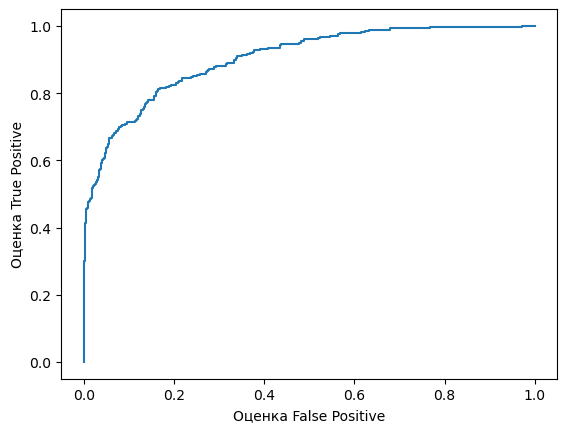

In [98]:
fpr, tpr, _ = roc_curve(target_test, grid_pipeline_2.best_estimator_.predict_proba(features_test_ordinal)[:, 1])
plt.plot (fpr,tpr)
plt.ylabel('Оценка True Positive')
plt.xlabel('Оценка False Positive')
plt.show() 

Значение roc-auc выше необходимого порога 0.86

Посмотрим на матрицу ошибок

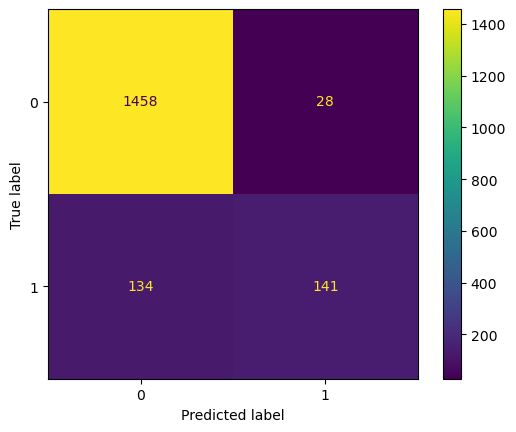

In [99]:
ax= confusion_matrix(target_test, grid_pipeline_2.best_estimator_.predict(features_test_ordinal))
disp = ConfusionMatrixDisplay(confusion_matrix=ax)
disp.plot()
plt.show()

Модель почти идеально предсказывает то, что человек останется, из-за дисбаланса классов, но почти в половине случаев не обнаруживает уход человека

Посмотрим точность модели

In [100]:
print('Значение accuracy:', accuracy_score(target_test, grid_pipeline_2.best_estimator_.predict(features_test_ordinal)))

Значение accuracy: 0.9080068143100511


Модель имеет высокую точность

Посмотрим, какие признаки наиболее важны при предсказании моделью

In [101]:
feature_importances = permutation_importance(
    grid_pipeline_2, features_train_ordinal, target_train, n_repeats=10, random_state=rand
)

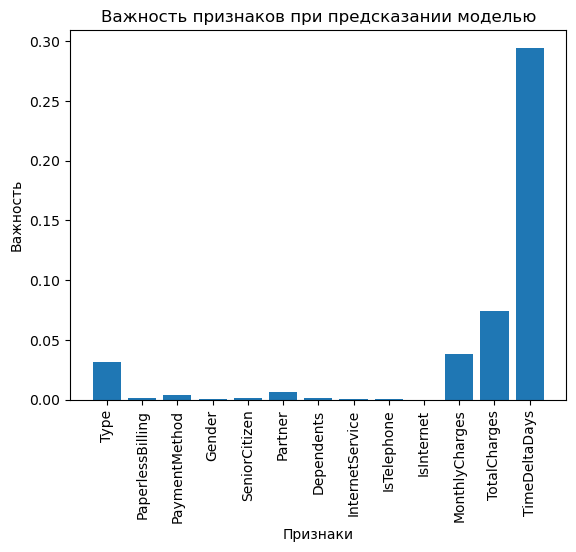

In [102]:
features = features_train_ordinal.columns
importances = feature_importances.importances_mean

plt.bar(features, importances)
plt.xticks(rotation=90)
plt.xlabel('Признаки')
plt.ylabel('Важность')
plt.title('Важность признаков при предсказании моделью')
plt.show()

Три самых важных признака: сколько по времени пользователь пользуется услугами, месячные и общие траты

Итог: 
- на тестовых данных получено значение roc-auc 0.9 для выбранной модели;
- модель почти идеально предсказывает то, что человек останется, из-за дисбаланса классов, но почти в половине случаев не обнаруживает уход человека;
- точность модели 0.9;
- три самых важных признака при обучении модели: сколько по времени пользователь пользуется услугами, месячные и общие траты.

## 6 Общий итог

1) Данные исследованы и предобработаны, проведен исследовательский анализ данных, говорящий о том, что отток пользователей уменьшается с 2014-го года, есть много совсем новых пользователей, при этом новые пользователи как легко приходят в больших количествах, так и уходят. Наиболее значимый фактор, влияющий на целевой признак - траты пользователя, на них же влияет подключение тех или иных услуг;


2) Данные подготовлены для обучения модели, проведен энкодинг, коллинеарные и бесполезные признаки убраны;


3) Обучено несколько моделей и выбрана наилучшая;


4) Метрики наилучшей модели на тестовых данных: 0.9 для auc-roc и 0.9 для accuracy. Три самых важных признака при обучении модели: сколько по времени пользователь пользуется услугами, месячные и общие траты.

## Отчет по решению

**1) Какие пункты плана были выполнены, а какие — нет. Почему?**  
Были выполнены все пункты плана  

**2) Какие трудности возникли и как вы их преодолели?**  
Из-за большого количества признаков их не очень удобно рассматривать визуально  

**3) Какие ключевые шаги в решении задачи вы выделили?**
- Предобработка данных;
- Исследовательский анализ;
- Подготовка данных к обучению;
- Обучение моделей;
- Тестирование итоговой модели.    

**4) Какие признаки использовали для обучения модели и какая предобработка этих признаков была выполнена?**  
Были использованы все признаки, кроме признаков, отвечающих за дополнительные функции, и дат. Дополнительно были выделены признаки, отвечающие за наличие телефонии, Интернета, а также количество дней с регистрации пользователя  

**5) Какая ваша итоговая модель, какие у неё гиперпараметы и какое качество?**  
Модель: LGBMClassifier, гиперпараметры: max_depth=5, n_estimators=500, random_state=280823. Качество модели: значение roc-auc 0.903, значение accuracy 0.908

Полученная roc-кривая:  
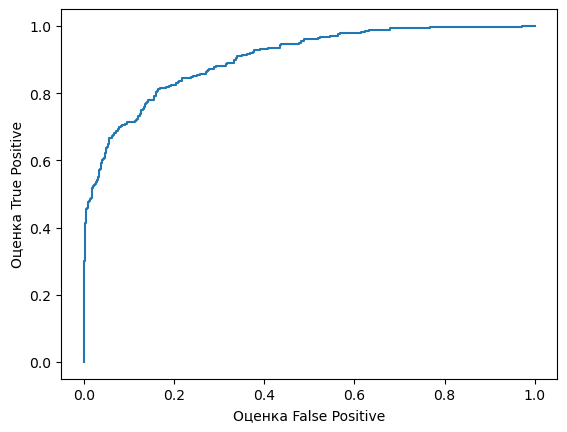  
Полученная матрица ошибок:  
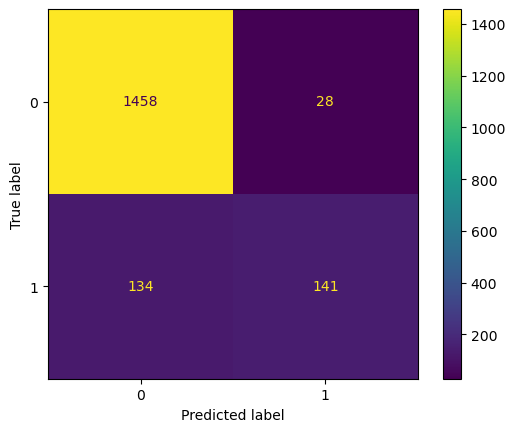  
Полученные важности признаков:  
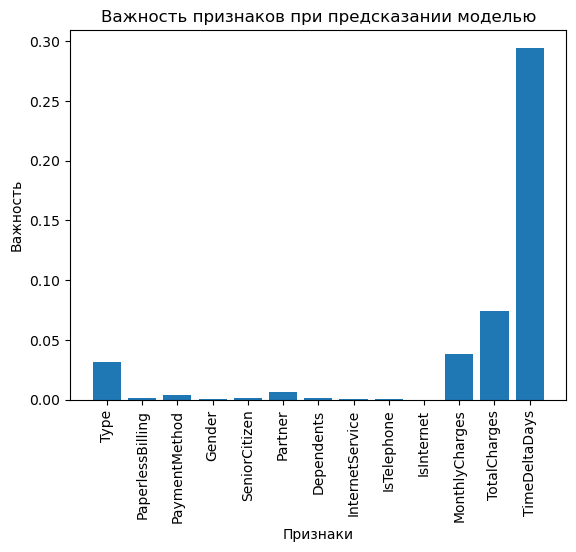